## Using a PINN to an ODE with two fixed points
ODE:  $dy/dt = Ry(1-y/K)$

This ODE (the logistic growth ODE) has a stable fixed point at y=K and
an unstable fixed point at y=0.

The unstable fixed point causes a problem, as shown below:


#### ODE Definition

In [1]:
def dydt(y,t):
    return R*y*(1-y/K)

R = 1
K = 5

y0 = 1 # Initial condition

Text(0.5, 1.0, 'True solution')

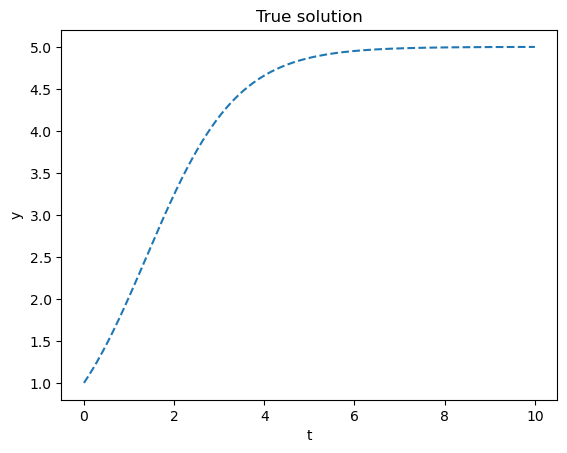

In [2]:
# True solution:

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

ts = np.linspace(0,10,1000)
ys = odeint(dydt,y0,ts)

plt.plot(ts,ys,'--')
plt.xlabel('t')
plt.ylabel('y')
plt.title('True solution')

### Trying a simple PINN

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Linear(1, 20),
    nn.Tanh(),
    nn.Linear(20, 20),
    nn.Tanh(),
    nn.Linear(20, 1)
)

ts_test = np.linspace(0,5,100)
ts_test_with_grad = torch.tensor(ts_test, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
def ODE_loss(model):
    ys_model = model(ts_test_with_grad)
    dydt_model = torch.autograd.grad(outputs=ys_model, inputs=ts_test_with_grad, 
                                     grad_outputs=torch.ones_like(ys_model), create_graph=True)[0]
    dydt_true = dydt(ys_model,ts_test_with_grad)
    return torch.mean((dydt_true - dydt_model)**2)

optimizer = optim.Adam(model.parameters(), lr=0.01)

# Initial time:
t0 = torch.tensor([[ts_test[0]]], dtype=torch.float32)

In [4]:
N_EPOCHS = 5000
for epoch in range(N_EPOCHS):
    # Loss is ODE_loss + Initial condition loss
    loss = ODE_loss(model) + 10*(model(t0) - y0)**2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%200 == 0:
        print('epoch:',epoch,"  loss=",loss.item())

epoch: 0   loss= 9.597273826599121
epoch: 200   loss= 0.34344738721847534
epoch: 400   loss= 0.34268423914909363
epoch: 600   loss= 0.3420565128326416
epoch: 800   loss= 0.3409288227558136
epoch: 1000   loss= 0.3392707407474518
epoch: 1200   loss= 0.3376024663448334
epoch: 1400   loss= 0.33554714918136597
epoch: 1600   loss= 0.32964497804641724
epoch: 1800   loss= 0.00014618424756918103
epoch: 2000   loss= 5.935751323704608e-05
epoch: 2200   loss= 3.303393168607727e-05
epoch: 2400   loss= 2.0169749404885806e-05
epoch: 2600   loss= 1.261809575225925e-05
epoch: 2800   loss= 8.737270945857745e-06
epoch: 3000   loss= 6.2780859479971696e-06
epoch: 3200   loss= 3.111883415840566e-05
epoch: 3400   loss= 2.7055286864197114e-06
epoch: 3600   loss= 2.1812395516462857e-06
epoch: 3800   loss= 2.004520865739323e-06
epoch: 4000   loss= 8.955544217315037e-06
epoch: 4200   loss= 1.2631360277737258e-06
epoch: 4400   loss= 1.50006655985635e-06
epoch: 4600   loss= 1.4903138207955635e-06
epoch: 4800   los

Text(0, 0.5, 'y')

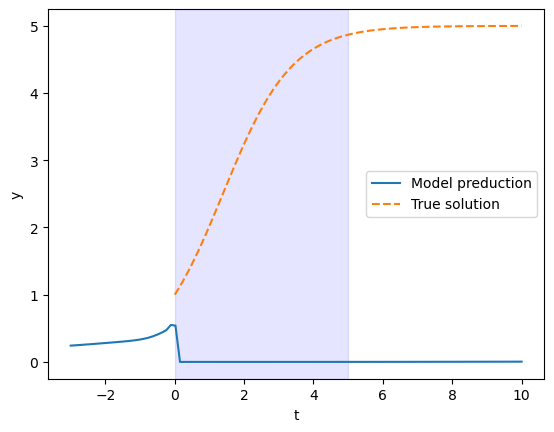

In [5]:
ts_test = np.linspace(-3,10,100)
ts_test_torch = torch.tensor(ts_test, dtype=torch.float32).reshape(-1, 1)
ys_model = model(ts_test_torch).detach().cpu().numpy()
plt.plot(ts_test,ys_model)
plt.plot(ts,ys,'--')
plt.legend(['Model preduction','True solution'])
plt.axvspan(0, 5, color='blue', alpha=0.1)
#plt.ylim(-1,3)
plt.xlabel('t')
plt.ylabel('y')

### This PINN doesn't work!

**The model gets stuck in the unstable steady state at y=0.**

Below penalize model outputs near y=0 with an additional term in the loss function.
This penalty fixes the problem (of course, we needed to know about the unstable 
steady state at y=0 in order to use this technique).

## Training with a new loss function

In [6]:
# New model to be trained with a penalty for solutions near y=0
model2 = nn.Sequential(
    nn.Linear(1, 20),
    nn.Tanh(),
    nn.Linear(20, 20),
    nn.Tanh(),
    nn.Linear(20, 1)
)

# New loss function to penalize y=0
def ODE_near0penalty_loss(model):
    ys_model = model(ts_test_with_grad)
    dydt_model = torch.autograd.grad(outputs=ys_model, inputs=ts_test_with_grad, 
                                     grad_outputs=torch.ones_like(ys_model), create_graph=True)[0]
    dydt_true = dydt(ys_model,ts_test_with_grad)
    #near_0_penalty = torch.mean(torch.exp(-100*ys_model))
    return torch.mean((dydt_true - dydt_model)**2) + torch.mean(torch.exp(-10*ys_model))

optimizer2 = optim.Adam(model2.parameters(), lr=0.01)

In [7]:
N_EPOCHS = 5000
for epoch in range(N_EPOCHS):
    # Loss is ODE_loss + Initial condition loss
    loss = ODE_near0penalty_loss(model2) + (model2(t0) - y0)**2

    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
    if epoch%200 == 0:
        print('epoch:',epoch,"  loss=",loss.item())

epoch: 0   loss= 1.0620379447937012
epoch: 200   loss= 0.31207770109176636
epoch: 400   loss= 0.00031391551601700485
epoch: 600   loss= 4.931279181619175e-05
epoch: 800   loss= 2.8623722755583003e-05
epoch: 1000   loss= 0.006093943957239389
epoch: 1200   loss= 1.1649264706647955e-05
epoch: 1400   loss= 7.440766694344347e-06
epoch: 1600   loss= 0.00010055096936412156
epoch: 1800   loss= 4.130035449634306e-06
epoch: 2000   loss= 7.381609066214878e-06
epoch: 2200   loss= 3.828289663942996e-06
epoch: 2400   loss= 3.520193786243908e-06
epoch: 2600   loss= 4.266817086318042e-06
epoch: 2800   loss= 3.1952158678905107e-06
epoch: 3000   loss= 3.218446181563195e-06
epoch: 3200   loss= 2.8856027256551897e-06
epoch: 3400   loss= 2.85183523374144e-06
epoch: 3600   loss= 2.3216905901790597e-05
epoch: 3800   loss= 2.498407184248208e-06
epoch: 4000   loss= 1.1726784578058869e-05
epoch: 4200   loss= 2.2413778424379416e-06
epoch: 4400   loss= 2.25315784518898e-06
epoch: 4600   loss= 2.0781608327524737e-

Text(0, 0.5, 'y')

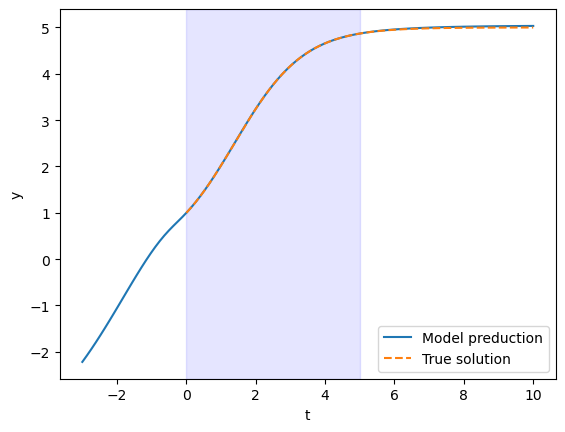

In [8]:
ts_test = np.linspace(-3,10,100)
ts_test_torch = torch.tensor(ts_test, dtype=torch.float32).reshape(-1, 1)
ys_model = model2(ts_test_torch).detach().cpu().numpy()
plt.plot(ts_test,ys_model)
plt.plot(ts,ys,'--')
plt.legend(['Model preduction','True solution'])
plt.axvspan(0, 5, color='blue', alpha=0.1)
#plt.ylim(-1,3)
plt.xlabel('t')
plt.ylabel('y')

The new loss function forces the model away from the unstable fixed point,
and the miodel